<a href="https://colab.research.google.com/github/Sevi9/colab/blob/main/KaggleHousePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#第一部分配置环境
from google.colab import drive
drive.mount('/content/drive')
import os
path = "/content/drive/MyDrive" 
os.chdir(path)
!ls


Mounted at /content/drive
'Colab Notebooks'   data    paddle    tensorflow      train_data.csv
 d2l-zh		    mxnet   pytorch   test_data.csv


In [ ]:
#第二部分下载资源
!mkdir d2l-zh && cd d2l-zh
!curl https://zh-v2.d2l.ai/d2l-zh.zip -o d2l-zh.zip
!unzip d2l-zh.zip && rm d2l-zh.zip
!pip install mxnet-cu101==1.7.0
!pip install -U d2l


In [ ]:
#第三部分进入文件夹下开始动手
import os
path = "/content/drive/MyDrive/d2l-zh" 
os.chdir(path)
import mxnet


In [ ]:
!pip install -U d2l

In [ ]:
!pip install matplotlib_inline


In [ ]:
!pip install matplotlib==3.0.0

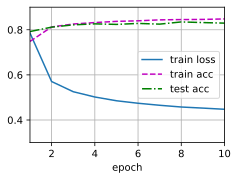

In [ ]:
#softmax回归的简洁实现
%matplotlib inline
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display
batch_size=256
num_inputs = 784
num_outputs = 10
w = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
#pytorch不会隐式地调整输入的形状，因此要定义展平层（flatten）在线性层前调整网络输入的形状
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))#flatten将任何维度的tensor变成2d的tensor，第0维度保留，剩下全部展成一个向量
def accuracy(y_hat,y):
  """计算预测正确的数量"""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # y_hat.shape[1]>1表示不止一个类别，每个类别有各自的概率   
    y_hat = y_hat.argmax(axis=1) # y_hat.argmax(axis=1)为求行最大值的索引
  cmp = y_hat.type(y.dtype) == y # 先判断逻辑运算符==，再赋值给cmp，cmp为布尔类型的数据
  return float(cmp.type(y.dtype).sum()) # 获得y.dtype的类型作为传入参数，将cmp的类型转为y的类型（int型），然后再求和   
# 可以评估在任意模型net的准确率
def evaluate_accuracy(net,data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module): # 如果net模型是torch.nn.Module实现的神经网络的话，将它变成评估模式     
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2) # 正确预测数、预测总数，metric为累加器的实例化对象，里面存了两个数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y),y.numel()) # net(X)将X输入模型，获得预测值。y.numel()为样本总数
    return metric[0] / metric[1] # 分类正确的样本数 / 总样本数
# 训练函数
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train() # 开启训练模式
  metric = Accumulator(3)
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat,y) # 计算损失
    if isinstance(updater,torch.optim.Optimizer): # 如果updater是pytorch的优化器的话
      updater.zero_grad()
      l.mean().backward()  # 这里对loss取了平均值出来
      updater.step()
      metric.add(float(l)*len(y),accuracy(y_hat,y),y.size().numel()) # 总的训练损失、样本正确数、样本总数   
    else:
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()),accuracy(y_hat,y),y.numel()) 
  return metric[0] / metric[2], metric[1] / metric[2] # 所有loss累加除以样本总数，总的正确个数除以样本总数  
class Accumulator:
  """在n个变量上累加"""
  def __init__(self,n):
    self.data = [0,0] * n
  def add(self, *args):
    self.data = [a+float(b) for a,b in zip(self.data,args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包....
        
  def reset(self):
    self.data = [0.0] * len(self.data)
        
  def __getitem__(self,idx):
    return self.data[idx]
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
# 总训练函数        
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
  animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],       
                       legend=['train loss','train acc','test acc'])
  for epoch in range(num_epochs):  # 变量num_epochs遍数据
   train_metrics = train_epoch_ch3(net,train_iter,loss,updater) # 返回两个值，一个总损失、一个总正确率
   test_acc = evaluate_accuracy(net,test_iter) # 测试数据集上评估精度，仅返回一个值，总正确率  
   animator.add(epoch+1,train_metrics+(test_acc,)) # train_metrics+(test_acc,) 仅将两个值的正确率相加，
   train_loss, train_acc = train_metrics  
def init_weights(m):#m为当前layer
  if type(m)==nn.Linear:
    nn.init.normal_(m.weight,std=0.01)#weight初始化为均值为0，标准差为0.01的随机值
net.apply(init_weights)#函数应用到net的每一层中完成初始化
loss=nn.CrossEntropyLoss(reduction="none")
trainer=torch.optim.SGD(net.parameters(),lr=0.1)#使用学习率为0.1的小批量随机梯度下降作为优化算法
#调用之前定义的训练函数来训练模型
num_epochs=10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)


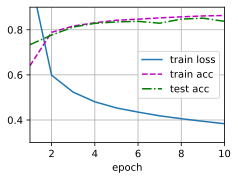

In [ ]:
#多层感知机从零开始实现
import torch
from torch import nn
from d2l import torch as d2l
batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
#实现一个单隐藏层的多层感知机，包含256个隐藏单元
num_inputs,num_outputs,num_hiddens=784,10,256
w1=nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True)*0.01)#随机行数为784，列数为256，×0.01为了把方差变为0.01
b1=nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))#normal和randn区别在于normal可以自己设定方差而randn只是生成
w2=nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2=nn.Parameter(torch.zeros(num_outputs,requires_grad=True))
params=[w1,b1,w2,b2]
#实现ReLU激活函数
def relu(x):
  a=torch.zeros_like(x)#与x形状一样但元素均为0
  return torch.max(x,a)
#实现模型
def net(x):
  x=x.reshape((-1,num_inputs))#x为batchsize*784
  h=relu(x@w1+b1)#@是矩阵相乘
  return (h@w2+b2)
loss=nn.CrossEntropyLoss(reduction="none")
#训练——多层感知机训练过程同softmax回归训练过程
num_epochs,lr=10,0.1
updater=torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)
#可对比上一张图的loss下降，精度没有改变太多，模型更大，数据拟合性更好，损失下降

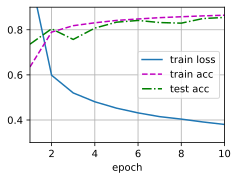

In [ ]:
#多层感知机的简洁实现
import torch
from torch import nn
from d2l import torch as d2l
net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

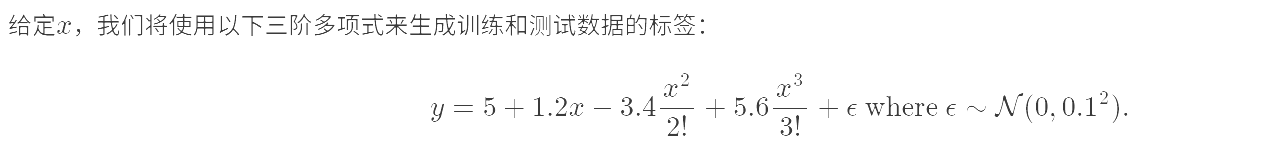

weight: [[ 4.928019    1.4552926  -3.0073779   4.580907   -1.0926691   1.0746306
  -0.31902525  0.12743907  0.07522329 -0.20615456  0.13807818 -0.03325684
  -0.22099763  0.02959972  0.18992363 -0.13275228 -0.01626485 -0.20111902
  -0.11352906  0.05544929]]


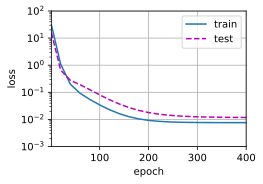

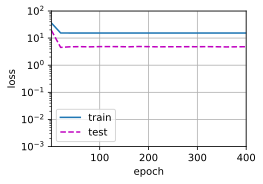

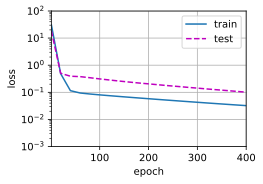

In [ ]:
from numpy.lib.polynomial import poly
#模型选择、欠拟合和过拟合
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
max_degree=20#输入特征数为20，产生20维向量
n_train,n_test=100,100
true_w=np.zeros(max_degree)
true_w[0:4]=np.array([5,1.2,-3.4,5.6])#w也为20，其余为0而已
features=np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
  poly_features[:,i]/=math.gamma(i+1)#gamma(n)=(n-1)!
labels=np.dot(poly_features,true_w)
labels+=np.random.normal(scale=0.1,size=labels.shape)
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]
features[:2],poly_features[:2,:],labels[:2]
#评估模型在给定数据集上的损失
def evaluate_loss(net,data_iter,loss):
  metric=d2l.Accumulator(2)
  for x,y in data_iter:
    out=net(x)
    y=y.reshape(out.shape)
    l=loss(out,y)
    metric.add(l.sum(),l.numel())
  return metric[0]/metric[1]
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
  loss=nn.MSELoss()
  input_shape=train_features.shape[-1]#表列数，行向量的元素总数
  net=nn.Sequential(nn.Linear(input_shape,1,bias=False))#单层线性网络softmax
  batch_size=min(10,train_labels.shape[0])#batchsize为10
  train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
  test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
  trainer=torch.optim.SGD(net.parameters(),lr=0.01)
  animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
  for epoch in range(num_epochs):
    d2l.train_epoch_ch3(net,train_iter,loss,trainer)
    if epoch==0 or (epoch+1)%20==0:
      animator.add(epoch+1,(evaluate_loss(net,train_iter,loss),evaluate_loss(net,test_iter,loss)))
  print('weight:',net[0].weight.data.numpy())
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])#从特征多项式中选取前四个维度
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])#欠拟合，只选了两个维度
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])#过拟合，所有维度都选择

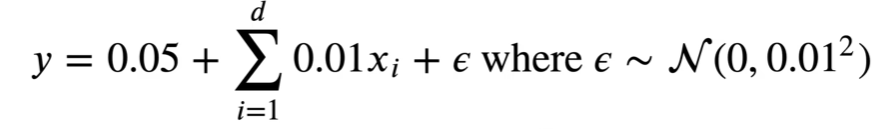

w的L2范数是： 0.3859468400478363


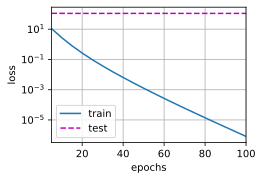

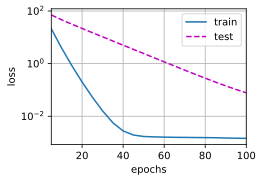

In [ ]:
#权重衰减
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
#生成数据如上图多项式
n_train,n_test,num_inputs,batch_size=20,100,200,5#选少的训练样本防止过拟合
true_w,true_b=torch.ones((num_inputs,1))*0.01,0.05
train_data=d2l.synthetic_data(true_w,true_b,n_train)
train_iter=d2l.load_array(train_data,batch_size)
test_data=d2l.synthetic_data(true_w,true_b,n_test)
test_iter=d2l.load_array(test_data,batch_size,is_train=False)
#初始化模型参数
def init_params():
  w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)#均值为0，方差为1，size为200*1的向量
  b=torch.zeros(1,requires_grad=True)
  return [w,b]
#定义L2范数惩罚项
def l2_penalty(w):
  return torch.sum(w.pow(2))/2#换成L1范数更新权重——torch.abs(w)
def train(lambd):
  w,b=init_params()
  net,loss=lambda x:d2l.linreg(x,w,b),d2l.squared_loss#lambda为匿名函数，相当于定义了一个net（x）
  num_epochs,lr=100,0.003
  animator=d2l.Animator(xlabel='epochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
  for epoch in range(num_epochs):
    for x,y in train_iter:
      with torch.enable_grad():
        l=loss(net(x),y)+lambd*l2_penalty(w)
      l.sum().backward()
      d2l.sgd([w,b],lr,batch_size)
    if (epoch+1)%5==0:
      animator.add(epoch+1,(d2l.evaluate_loss(net,train_iter,loss),d2l.evaluate_loss(net,test_iter,loss)))
  print('w的L2范数是：',torch.norm(w).item())
train(lambd=0)#没有L2范数可以看出过拟合明显
train(lambd=3)#去过拟合效果明显


w的L2范数： 0.3862219750881195


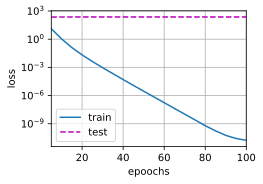

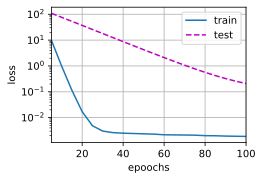

In [ ]:
#权重衰减的简洁实现
def train_concise(wd):
  net=nn.Sequential(nn.Linear(num_inputs,1))
  for param in net.parameters():
    param.data.normal_()
  loss=nn.MSELoss()
  num_epochs,lr=100,0.003
  #基本所有优化算法都会提供weight decay项
  trainer=torch.optim.SGD([{"params": net[0].weight,'weight_decay': wd},{"params":net[0].bias}],lr=lr)#net[0]指的是nn.Sequential里的第一个全连接层
  animator=d2l.Animator(xlabel='epoochs',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])
  for epoch in range(num_epochs):
    for x,y in train_iter:
      with torch.enable_grad():
        trainer.zero_grad()
        l=loss(net(x),y)
      l.backward()
      trainer.step()
    if (epoch + 1) % 5 == 0:
      animator.add(epoch + 1,
                   (d2l.evaluate_loss(net, train_iter, loss),
                    d2l.evaluate_loss(net, test_iter, loss)))
  print('w的L2范数：', net[0].weight.norm().item())
train_concise(0)
train_concise(3)

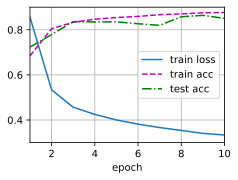

In [ ]:
#dropout的实现
import torch 
from torch import nn
from d2l import torch as d2l
def dropout_layer(x,dropout):
  assert 0<=dropout<=1#判断assert后的表达式是否为true，若为true就继续执行下面代码否则触发异常
  if dropout==1:
    return torch.zeros_like(x)
  if dropout==0:
    return x
  mask=(torch.rand(x.shape)>dropout).float()#mask是一个与x shape相同的布尔矩阵，代表哪些位置保留，哪些位置dropout，mask为一个x.shape维度的0，1数组
  #转换为01的float便于return
  return mask*x/(1.0-dropout)
x=torch.arange(16,dtype=torch.float32).reshape((2,8))
print(x),print(dropout_layer(x,0.)),print(dropout_layer(x,0.5)),print(dropout_layer(x,1.))
#定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元
num_inputs,num_outputs,num_hidden1,num_hidden2=784,10,256,256
dropout1,dropout2=0.2,0.5
class Net(nn.Module):
  def __init__(self,num_inputs,num_outputs,num_hidden1,num_hidden2,is_training=True):#注意istraining=true才使用dropout
    super(Net,self).__init__()
    self.num_inputs=num_inputs
    self.training=is_training
    self.lin1=nn.Linear(num_inputs,num_hidden1)
    self.lin2=nn.Linear(num_hidden1,num_hidden2)
    self.lin3=nn.Linear(num_hidden2,num_outputs)
    self.relu=nn.ReLU()
  def forward(self,x):#实例化Net后自动调用forward
    h1=self.relu(self.lin1(x.reshape((-1,self.num_inputs))))
    if self.training==True:#若在训练则作用dropout
      h1=dropout_layer(h1,dropout1)
    h2=self.relu(self.lin2(h1))
    if self.training==True:#同上
      h2=dropout_layer(h2,dropout2)
    out=self.lin3(h2)
    return out
net=Net(num_inputs,num_outputs,num_hidden1,num_hidden2)
num_epochs,lr,batch_size=10,0.5,256
loss=nn.CrossEntropyLoss(reduction="none")
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
trainer=torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

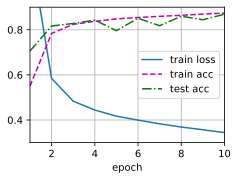

In [ ]:
#dropout的简洁实现
net=nn.Sequential(
    nn.Flatten(),nn.Linear(784,256),nn.ReLU(),#先将输入拉平flatten为2维图像，第一个全连接层
    nn.Dropout(dropout1),nn.Linear(256,256),nn.ReLU(),#加入dropout layer
    nn.Dropout(dropout2),nn.Linear(256,10)#加入dropout layer
)
def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights);
trainer=torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
fold1,train log rmse0.045845,valid log rmse0.166120
fold2,train log rmse0.058781,valid log rmse0.125656
fold3,train log rmse0.093424,valid log rmse1.003760
fold4,train log rmse0.341101,valid log rmse0.185708
fold5,train log rmse0.037132,valid log rmse0.188469
fold6,train log rmse0.049618,valid log rmse0.161300
fold7,train log rmse0.021918,valid log rmse0.158192
fold8,train log rmse0.040103,valid log rmse0.124278
fold9,train log rmse0.040749,valid log rmse0.177709
fold10,train log rmse0.037105,valid log rmse0.146718
10-折验证：平均训练log rmse：0.076578,平均验证log rmse：0.243791
train log rmse0.073714


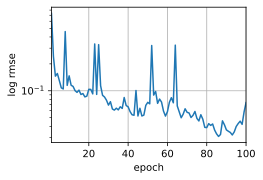

In [ ]:
#kaggle预测房价
import hashlib
import os
import tarfile
import zipfile
import requests
DATA_HUB=dict()#建立字典DATA_HUB
#它可以将数据集名称的字符串映射到数据集相关的二元组上，这个二元组包含数据集的url和验证文件完整性的sha-1密钥。
DATA_URL='https://d2l-data.s3-accelerate.amazonaws.com/'#https解决No schema supplied错误
def download(name,cache_dir=os.path.join('..','data')):
  #下载一个DATA_HUB中的文件返回本地文件名
  assert name in DATA_HUB,f"{name} 不存在于 {DATA_HUB}."
  url,shal_hash=DATA_HUB[name]# 获取DATA_HUB字典中给定名称对应的两个值：url 和 sha1_hash
  os.makedirs(cache_dir,exist_ok=True)#递归创建目录
  #exist_ok：如果已经存在怎么处理，默认是False，即：已经存在程序报错。当为True时，创建目录的时候如果已经存在就不报错。
  fname=os.path.join(cache_dir,url.split('/')[-1])
  #fname是文件的本地文件名，cache_dir是传入download函数的参数，表示缓存文件的目录。
  #url.split(‘/’)是把url按照’/‘进行分割，并返回一个列表，url.split(’/')[-1]表示取最后一个元素，也就是文件名
  #这条语句的目的是将缓存目录和文件名连接起来，构造出本地文件的绝对路径。
  #例如，如果缓存目录为 ‘…/data’，文件 URL 为 'http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv'
  #则本地文件名 fname 就会是 ‘…/data/kaggle_house_pred_train.csv’
  if os.path.exists(fname):
    #如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使用缓存的文件，以避免重复的下载。
    shal=hashlib.sha1()#这里hashlib.sha1为数字1
    with open(fname,'rb') as f:#意味着从文件中读取的所有数据将作为bytes对象，而不是str
      while True:
        data=f.read(1048576)#这里进行数据集的读取，一次能够读取的最大行数为1048576
        #每次读取1048576字节,也就是1MB
        if not data: # 如果读取到某一次不成功
          break
        shal.update(data)
    if shal.hexdigest()==shal_hash:
      return fname#命中缓存
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url,stream=True,verify=True)
  #向链接发送请求，第二个参数是不立即下载，当数据迭代器访问的时候再去下载那部分，不然全部载入会爆内存，第三个参数为不验证证书
  with open(fname, 'wb') as f:
    #‘wb’ – 二进制写入模式。和w一样，只是数据是二进制的
    f.write(r.content)
  return fname
def download_extract(name, folder=None): 
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    #获取文件的路径，fname是一个相对路径，那么就返回从当前文件到目标文件的路径
    data_dir, ext = os.path.splitext(fname)
    #将这个路径最后的文件名分割，返回路径+文件名，和一个文件的扩展名
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)# 解压压缩包内的所有文件到base_dir
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)
#使用pandas读入并处理数据
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
DATA_HUB['kaggle_house_train']=(DATA_URL+'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')#DATA_HUB包括文件名，其url和sha1密钥
DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')  
train_data=pd.read_csv(download('kaggle_house_train'))
test_data=pd.read_csv(download('kaggle_house_test'))
print(train_data.shape)
print(test_data.shape) 
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])#查看训练数据集的前4个样本的前4个特征、后两个特征和标签
#因为第一个特征为ID故删除
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
#iloc遵循左闭右开原则所以traindata包含最后一列，这里iloc切片索引删除了traindata的第一列和最后一列
#将训练数据集和测试数据集纵向连接在一起
#将所有缺失值替换为相应特征的平均值，通过将特征重新缩放到零均值和单位方差来标准化数据，即列值进行缩放变成正态分布
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index #在panda中object类型代表字符串
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
#训练集和测试集放到一起算均值方差，均值为0，方差为1
all_features[numeric_features]=all_features[numeric_features].fillna(0)#把not a number（未特征采样的data）填充为0
#处理离散值,对字符串类型用一次独热编码替换，即处理字符串变量
all_features=pd.get_dummies(all_features,dummy_na=True)#哑元变量，dummy_na设为True时，对nan类型也进行编码
all_features.shape
#从pandas格式中提取numpy格式并将其转换为张量表示
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
#理解为切片，定义起始位置和终止位置，features中train和test合并，这里要分开
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)
#训练
loss=nn.MSELoss()
in_features=train_features.shape[1]#in_feature=331，即特征的个数
def get_net():
  net=nn.Sequential(nn.Linear(in_features,256),nn.ReLU(),nn.Linear(256,1))#单层线性回归
  return net
#关心相对误差(y-y^)/y用价格预测的对数来衡量差异
def log_rmse(net,features,labels):
  clipped_preds=torch.clamp(net(features),1,float('inf'))#clamp限制输出为1到正无穷
  #clipped第一个为要约束的参数，第二个为最小值，第三个为最大值，小于最小值就为1
  rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))#一般y取log后会更接近正态分布，用回归性质比较好
  return rmse.item()
#训练函数将借助Adam优化器
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
  train_ls,test_ls=[],[]
  train_iter=d2l.load_array((train_features,train_labels),batch_size)
  optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)#可以理解为平滑的SGD，对学习率较为不敏感，但SGD上限更高
  for epoch in range(num_epochs):
    for x,y in train_iter:
      optimizer.zero_grad()#梯度先清零
      l=loss(net(x),y)#计算损失
      l.backward()#反向传播计算梯度
      optimizer.step()#更新参数
    train_ls.append(log_rmse(net,train_features,train_labels))#将log_rmse添加到train_ls的列表中
    if test_labels is not None:
      test_ls.append(log_rmse(net,test_features,test_labels))
  return train_ls,test_ls
#K折交叉验证
def get_k_fold_data(k,i,x,y):
  assert k>1
  fold_size=x.shape[0]//k#每一折为样本数/k
  x_train,y_train=None,None
  for j in range(k):
    idx=slice(j*fold_size,(j+1)*fold_size)#切片：class slice(start, stop[, step]) 
    #start -- 起始位置 stop -- 结束位置 step -- 间距
    x_part,y_part=x[idx,:],y[idx] # 将切片对象应用于索引
    if j==i:#j等于当前折数i，把这一折作为验证集，其余作为训练集
      x_valid,y_valid=x_part,y_part
    elif x_train is None:#还没有第一次看到就先存起来
      x_train,y_train=x_part,y_part
    else:#train和part concat起来做训练集
      x_train=torch.cat([x_train,x_part],0)#按维数0拼接（竖着拼）行拼接，按维数1拼接（横着拼）列拼接
      y_train=torch.cat([y_train,y_part],0)
  return x_train,y_train,x_valid,y_valid#最后返回训练集和验证集
#返回训练和验证误差的平均值
def k_fold(k,x_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
  train_l_sum,valid_l_sum=0,0
  for i in range(k):
    data=get_k_fold_data(k,i,x_train,y_train)
    net=get_net()
    train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)#*为解码，变成前面返回的四个数据
    train_l_sum+=train_ls[-1]#-1代表只取每一折最后一轮的损失loss
    valid_l_sum+=valid_ls[-1]
    if i==0:
      d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
    print(f'fold{i+1},train log rmse{float(train_ls[-1]):f},'f'valid log rmse{float(valid_ls[-1]):f}')
  return train_l_sum/k,valid_l_sum/k#loss求和做平均
k,num_epochs,lr,weight_decay,batch_size=10,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}')#train和valid重合较好，只能说没有overfitting但不能评价是好是坏
#提交自己的kaggle预测
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):#将调好的超参放到完整的训练集上训练一次
  net=get_net()
  train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
  d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',ylabel='log rmse',xlim=[1,num_epochs],yscale='log')
  print(f'train log rmse{float(train_ls[-1]):f}')
  preds=net(test_features).detach().numpy()#测试集无标注，将网络应用到测试集
  #将其重新格式化以导出到Kaggle
  test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
  #Pandas Series 类似表格中的一个列（column），类似于一维数组，可以保存任何数据类型。
  submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
  submission.to_csv('submission.csv',index=False)#submission为kaggle上要提交的文件
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)

In [ ]:
!pip install pandas==0.20.3

In [2]:
#竞赛 房价预测
#数据预处理及直观图像
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy.stats import norm,skew#获取统计信息
from scipy import stats#离散统计分布以及连续统计分布
import seaborn as sns#绘图包
color=sns.color_palette()
sns.set_style('darkgrid')
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.float_format',lambda x: '{:.3f}'.format(x))#限制浮点输出到小数点后3位
import os
train=pd.read_csv('/content/drive/MyDrive/data/kaggle/train.csv')
test=pd.read_csv('/content/drive/MyDrive/data/kaggle/test.csv')
print("训练集初始大小：{}".format(train.shape))
print("测试集初始大小：{}".format(test.shape))
print(train.head())#查看前五行数据
print(test.head())

训练集初始大小：(1460, 81)
测试集初始大小：(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg   
1   2          20       RL       80.000     9600   Pave   NaN      Reg   
2   3          60       RL       68.000    11250   Pave   NaN      IR1   
3   4          70       RL       60.000     9550   Pave   NaN      IR1   
4   5          60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondit

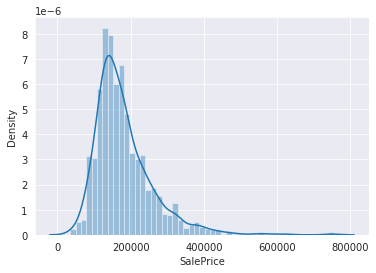

In [3]:
#训练集比测试集多一列价格，即测试集的预测目标
#删除原数据集的Id列
train.drop("Id",axis=1,inplace=True)
test.drop("Id",axis=1,inplace=True)
#目标值分析
#查看分布情况，绘制目标值分布
sns.distplot(train['SalePrice'])
plt.show()

In [4]:
#为明显的右偏分布，与正态分布有较大差距，再看分布曲线的峰度和偏度
SP_skew=train['SalePrice'].skew()
SP_kurt=train['SalePrice'].kurt()
print("峰度：",SP_skew)
print("偏度：",SP_kurt)
#峰度（Kurtosis）是描述总体中所有取值分布形态陡缓程度的统计量，是与正态分布作比较的。
#峰度为0表示该总体数据分布与正态分布的陡缓程度相同；
#峰度大于0表示该总体数据分布与正态分布相比较为陡峭，为尖顶峰；
#峰度小于0表示该总体数据分布与正态分布相比较为平坦，为平顶峰。
#偏度（Skewness）描述的是某总体取值分布的对称性，同样与正态分布相比较。
#偏度为0表示其数据分布形态与正态分布的偏斜程度相同；
#偏度大于0表示其数据分布形态与正态分布相比为正偏或右偏，即有一条长尾巴拖在右边，数据右端有较多的极端值；(长尾效应？)
#偏度小于0表示其数据分布形态与正态分布相比为负偏或左偏。
#结合图可知数据为尖顶峰右偏分布

#查看目标值统计信息
print(train['SalePrice'].describe())

峰度： 1.8828757597682129
偏度： 6.536281860064529
count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


In [ ]:
#最大值过大，取75%都与最大值相差很多，判断最大值附近应有异常值存在

In [5]:
#特征与目标值相关性（观察各个特征值与目标值之间的关系，这里要分开类别特征和数字特征）
num_features=[]
cate_features=[]
for col in test.columns:
  if test[col].dtype=='object':
    cate_features.append(col)
  else:
    num_features.append(col)
print('数值型特征：',len(num_features))
print('类别型特征：',len(cate_features))

数值型特征： 36
类别型特征： 43


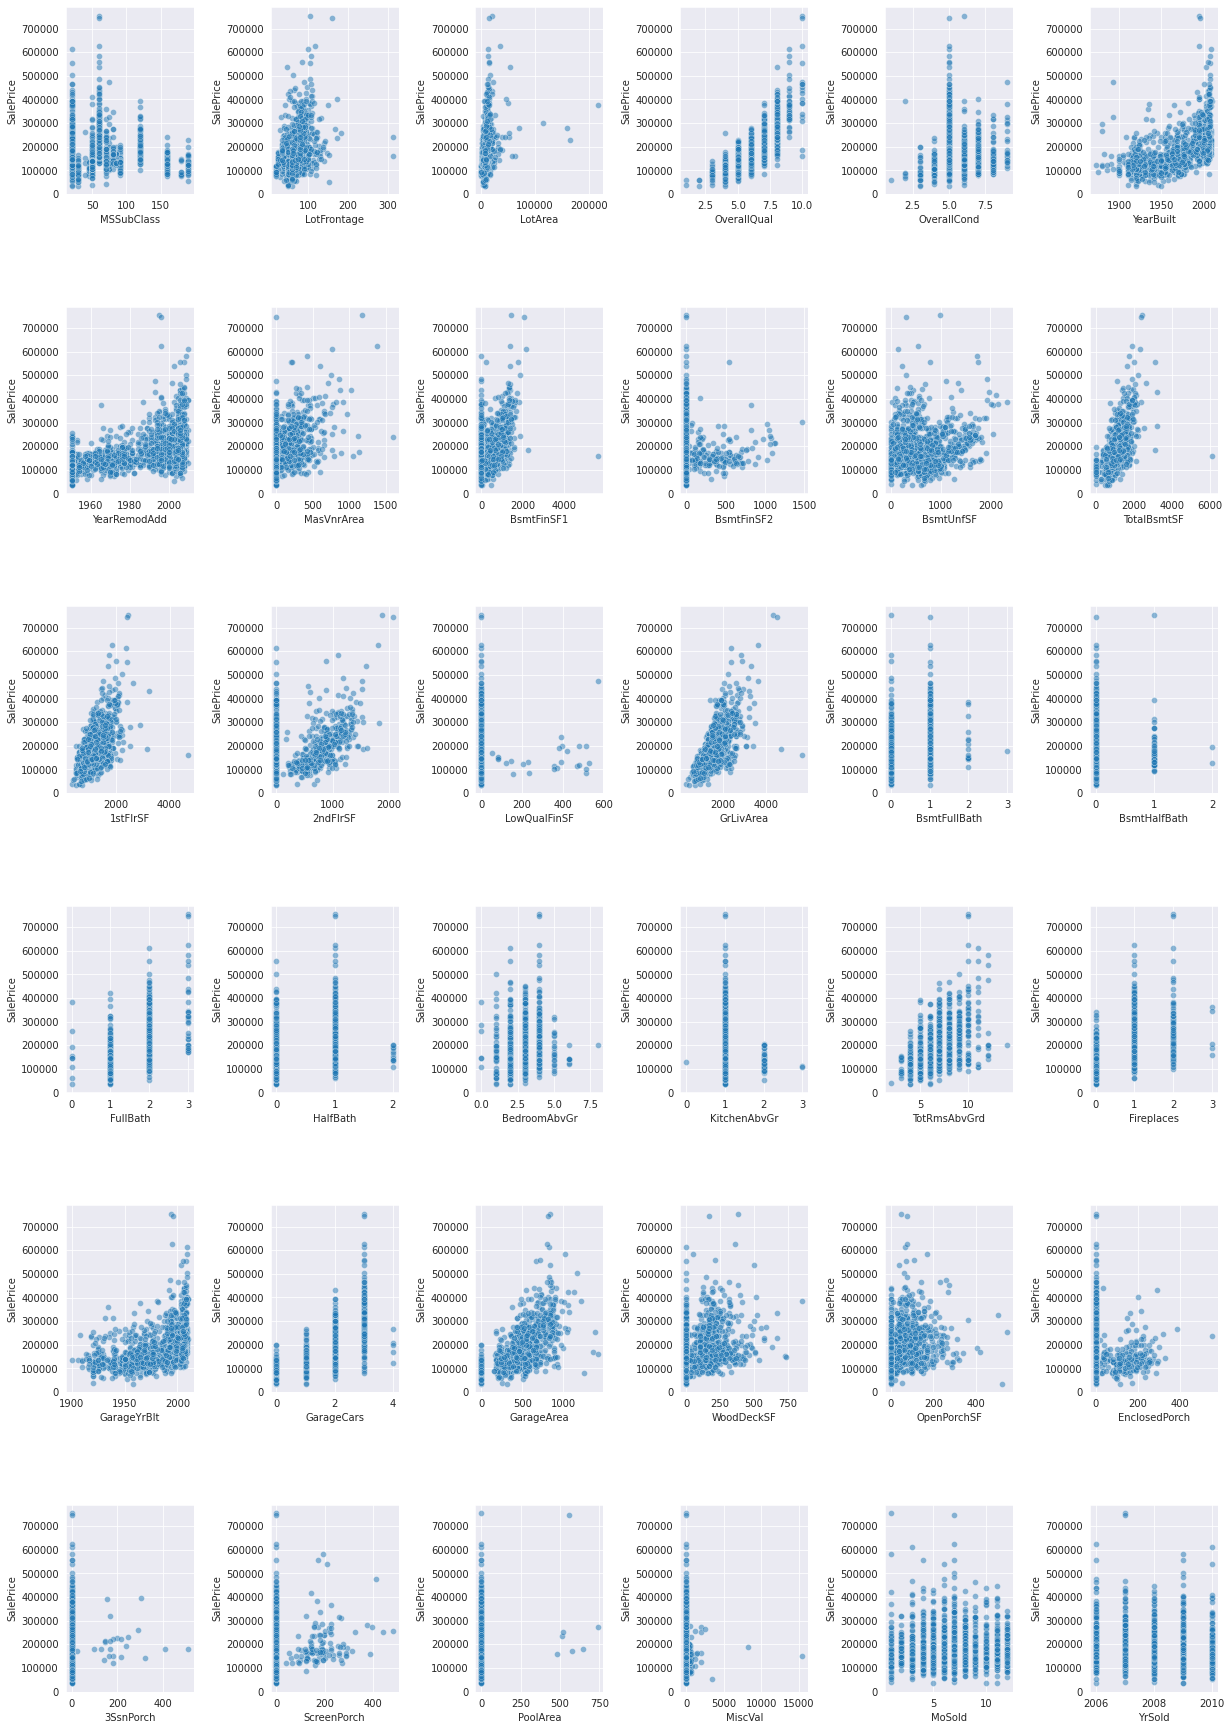

In [6]:
#采用散点图观察各个特征值与目标值之间的关系
plt.figure(figsize=(20,30))
plt.subplots_adjust(left=0.1,bottom=0.1,wspace=0.6,hspace=0.6)
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
#有六个可选参数来控制子图布局。值均为0~1之间。其中left、bottom、right、top围成的区域就是子图的区域
#wspace、hspace分别表示子图之间左右、上下的间距。实际的默认值由matplotlibrc文件控制的。
for i,feature in enumerate(num_features):
  plt.subplot(6,6,i+1)
  sns.scatterplot(x=feature,y='SalePrice',data=train,alpha=0.5)
  #matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, 
  #vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, data=None, **kwargs)
  #1 x，y：表示的是大小为(n,)的数组，也就是我们即将绘制散点图的数据点，相当于是x、y轴坐标
  #2 s:是一个实数或者是一个数组大小为(n,)，这个是一个可选的参数。可理解为散点的的点的大小
  #3 c:表示的是颜色，也是一个可选项。默认是蓝色'b',表示的是标记的颜色，或者可以是一个表示颜色的字符，或者是一个长度为n的表示颜色的序列等等，感觉还没用到过现在不解释了。但是c不可以是一个单独的RGB数字，也不可以是一个RGBA的序列。可以是他们的2维数组（只有一行）。
  #4 marker:表示的是标记的样式，默认的是'o'。
  #5 cmap:Colormap实体或者是一个colormap的名字，cmap仅仅当c是一个浮点数数组的时候才使用。如果没有申明就是image.cmap
  #6 norm:Normalize实体来将数据亮度转化到0-1之间，也是只有c是一个浮点数的数组的时候才使用。如果没有申明，就是默认为colors.Normalize。
  #7 vmin,vmax:实数，当norm存在的时候忽略。用来进行亮度数据的归一化。
  #8 alpha：实数，0-1之间。
  #9 linewidths:也就是标记点的长度。
  plt.xlabel(feature)
  plt.ylabel('SalePrice')
plt.show()

In [ ]:
#通过散点图发现，“GrLivArea”（地上生活面积）、“TotalBsmtSF”（地下室总面积）、“1stFlrSF”（一层面积）、“2ndFlrSF”（二层面积）
#这几个数据与目标值呈现明显的线性关系，他们都是与面积相关的，后续可以构造新特征，这也符合常理。


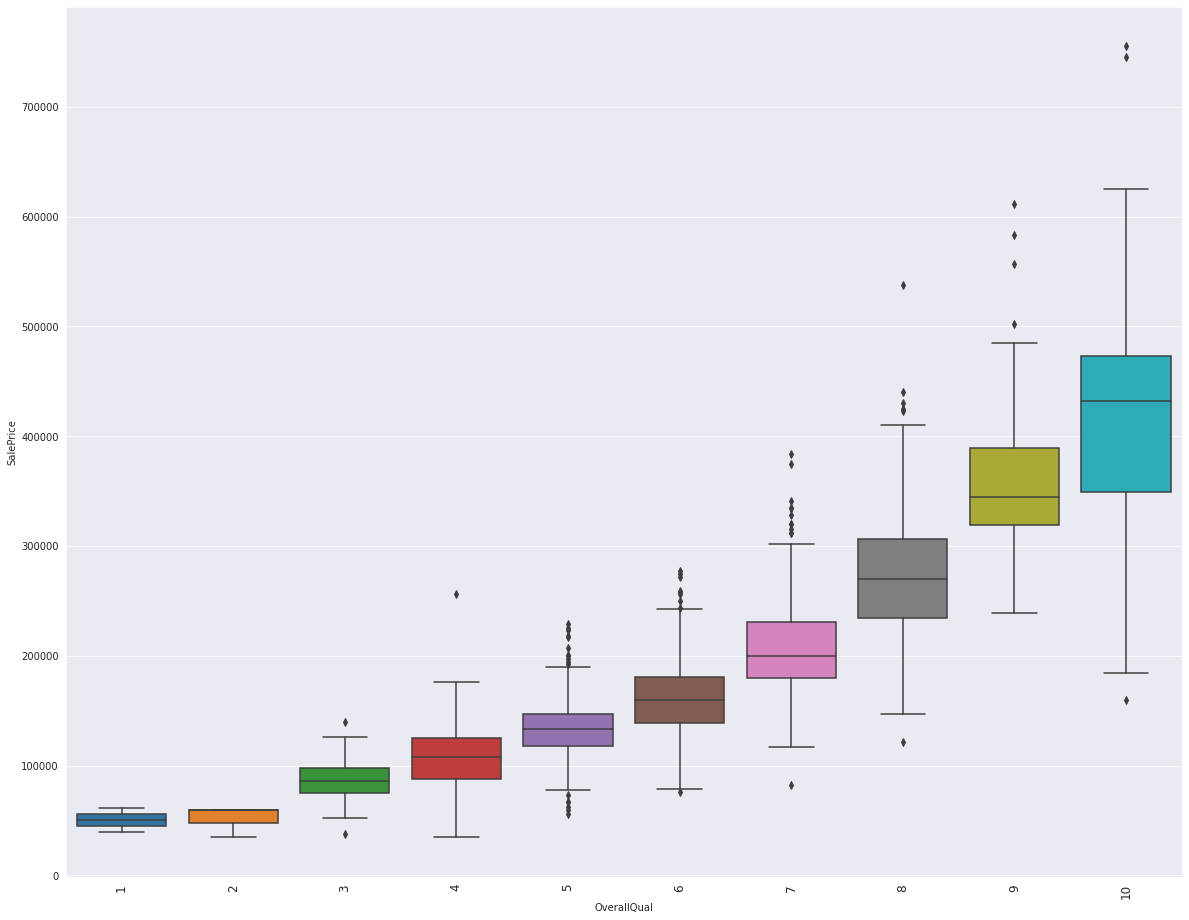

In [7]:
#然后再查看一些类别型变量与目标值的关系，用箱型图表示：
#上图中的“OverallQual”（房子材料与装修水平）虽然是数值型数据，但是数值实际代表类别，与目标值有明显相关性：
plt.figure(figsize=(20,16))
sns.boxplot(x='OverallQual',y='SalePrice',data=train)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.xticks(rotation=90,fontsize=12)
plt.show()

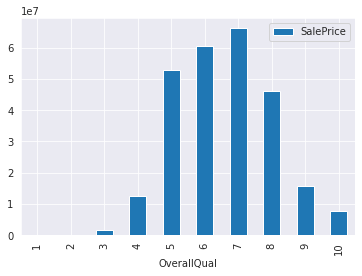

In [8]:
#可见装修水平越高售价越高，但并不意味着购买的人多，通过计算不同装修水平的售出价总和判断哪个装修水平最受青睐：
#柱状图
OverallQual_SalePrice=train[['OverallQual','SalePrice']].groupby(['OverallQual']).sum().sort_values(by='OverallQual',ascending=True)
#默认升序排列
OverallQual_SalePrice.plot(kind='bar')
plt.show()

In [ ]:
#可见5，6，7级装修水平最受买房者青睐

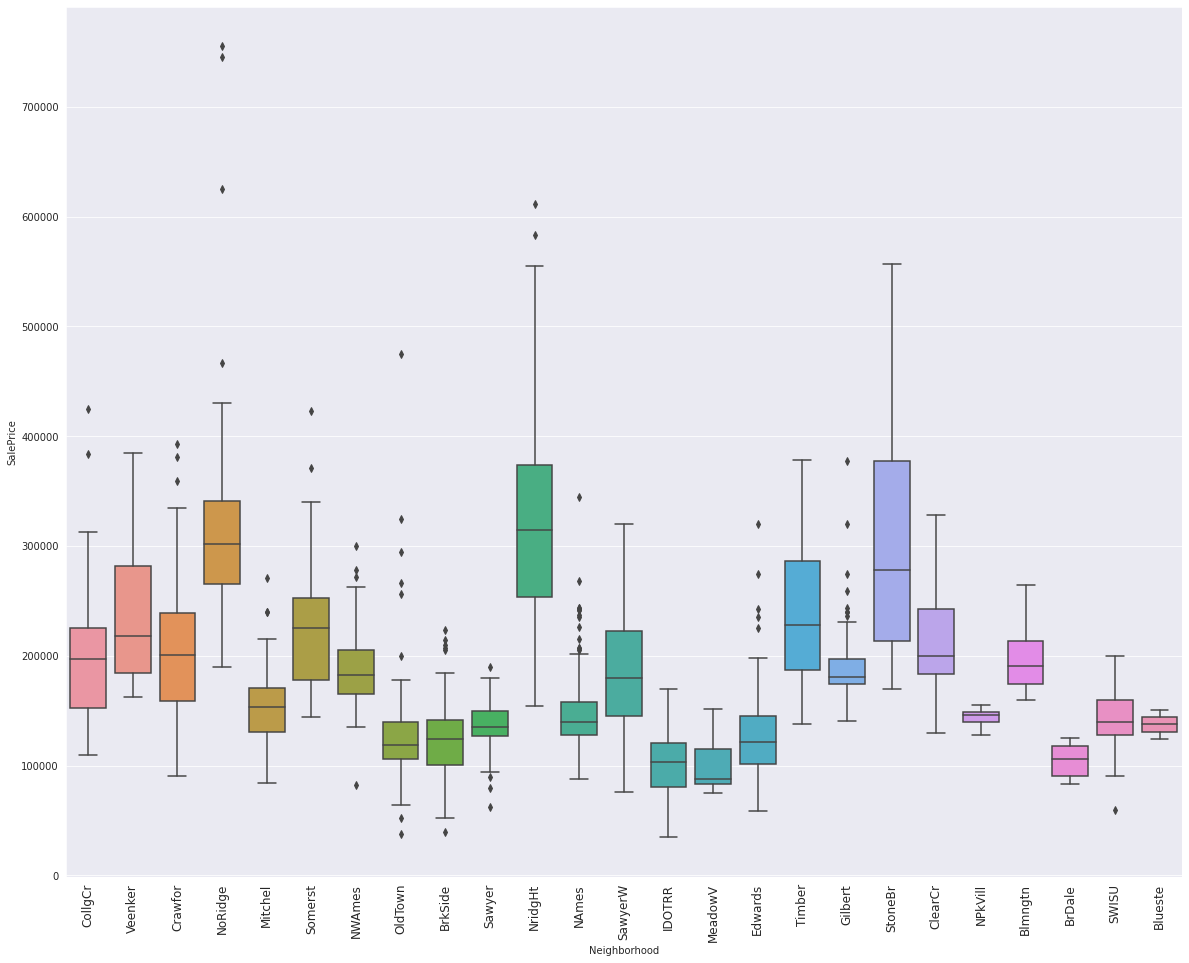

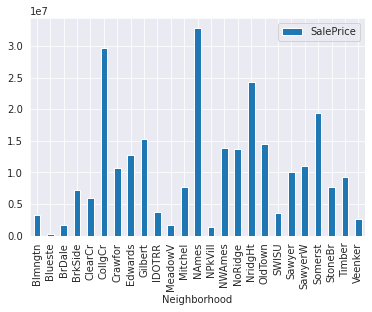

In [9]:
#再看重要的Neighborhood（街区位置）与房价的关系
plt.figure(figsize=(20,16))
sns.boxplot(x='Neighborhood',y='SalePrice',data=train)
plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')
plt.xticks(rotation=90,fontsize=12)
plt.show()
Neighborhood_SalePrice=train[['Neighborhood','SalePrice']].groupby(['Neighborhood']).sum().sort_values(by='Neighborhood',ascending=True)
Neighborhood_SalePrice.plot(kind='bar')
plt.show()

In [ ]:
#可见不同街区对应不同价格，NAmes和CollgCr地段最贵

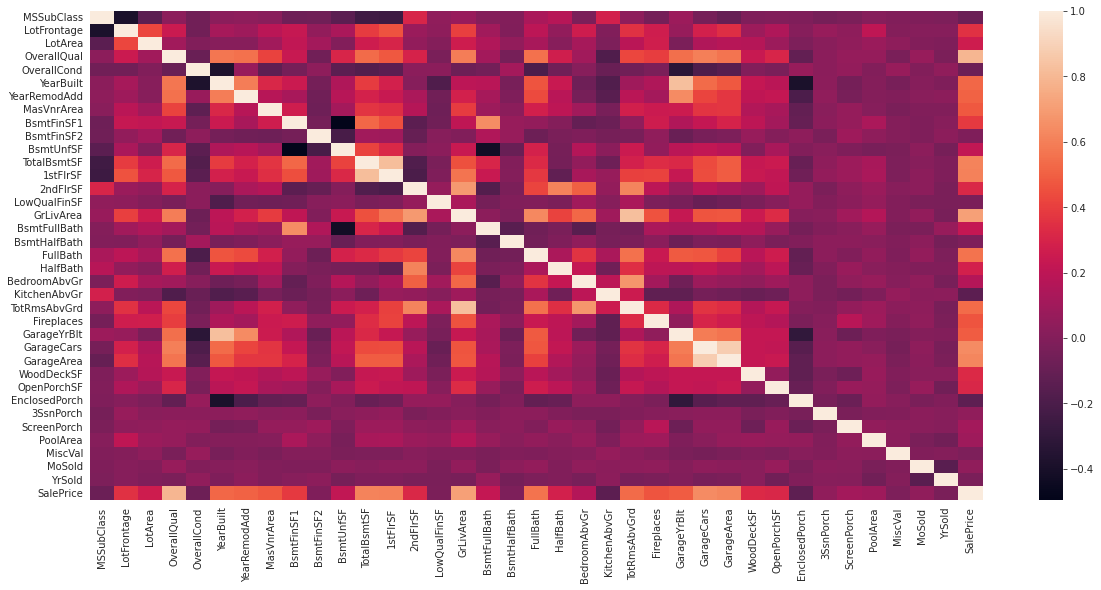

In [10]:
#看变量之间的相关性
#多变量分析
corrs=train.corr()
plt.figure(figsize=(20,9))
sns.heatmap(corrs)
plt.show()

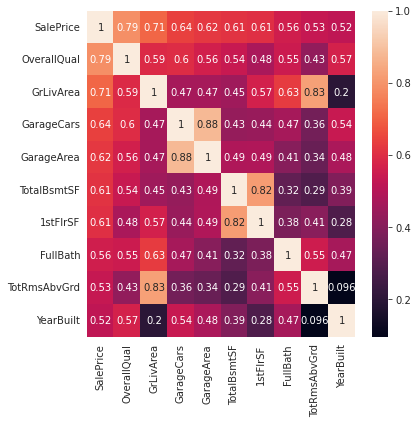

In [11]:
#由于特征较多选取与目标值相关度最高的十个变量再次分析
corrs=train.corr()
cols_10=corrs.nlargest(10,'SalePrice')['SalePrice'].index
corrs_10=train[cols_10].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corrs_10,annot=True)
plt.show()

处理后峰度 0.12134661989685333
处理后偏度 0.809519155707878


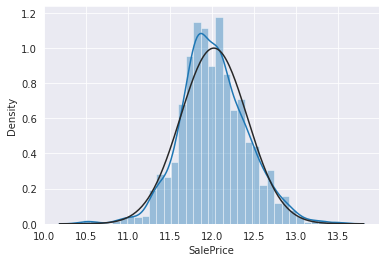

In [12]:
#数据预处理
#目标变量正态分布化——采用对数变换，线性回归模型要求变量为正态分布
y=train['SalePrice']
y=np.log1p(y)
sns.distplot(y,fit=norm)
print('处理后峰度',y.skew())
print('处理后偏度',y.kurtosis())
plt.show()

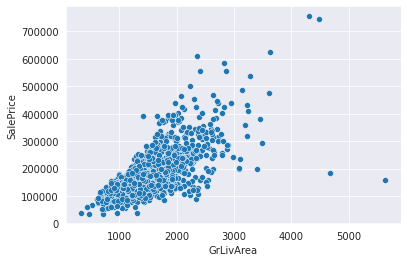

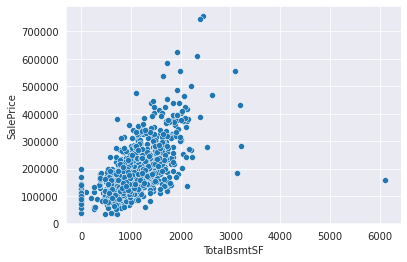

In [13]:
#异常值处理
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train)
plt.show()
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=train)
plt.show()

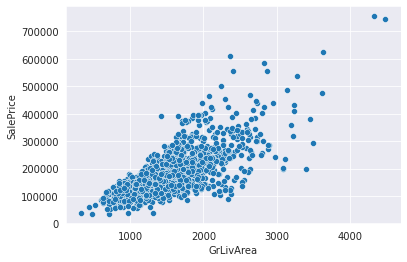

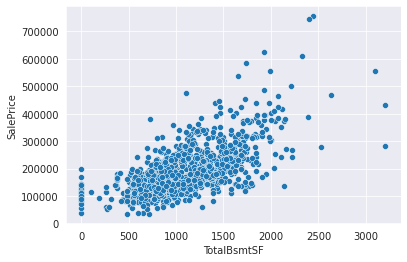

In [14]:
#发现右下角有明显的异常值，去掉异常值，同时也去掉了TotalBsmtSF的异常值
train=train.drop(train[(train['GrLivArea']>4000)&(train['SalePrice']<200000)].index)
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train)
plt.show()
sns.scatterplot(x='TotalBsmtSF',y='SalePrice',data=train)
plt.show()

In [15]:
#将训练集和测试集拼在一起进行处理实际上会造成数据泄露，应先处理训练集数据再用训练集数据同样处理测试集
#先看训练集的缺失值个数
train_nan=train.isnull().sum()
train_nan=train_nan.drop(train_nan[train_nan==0].index).sort_values(ascending=False)
print(train_nan)

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [16]:
#测试集与训练集相似，下面填补缺失值
#类别特征缺失值
#在data_description.txt中已有说明，一部分特征值的缺失是因为这些房子根本没有该项特征，对于这种情况我们统一用“None”或者“0”来填充。
#Python中的None是一个特殊常量，不是0，也不是False，不是空字符串，更多的是表示一种不存在，是真正的空。它就是一个空的对象，只是没有赋值而已。
#如PoolQC确实的意思是 表示“没有泳池”。
#以下这些类别的缺失值填充为None：
none_lists = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1',
              'BsmtFinType2', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType']
for col in none_lists:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')
#对于缺失值较少的离散型特征如Electrical，用众数填补缺失值
most_lists=['MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical']
for col in most_lists:
  train[col]=train[col].fillna(train[col].mode()[0])
  test[col]=test[col].fillna(train[col].mode()[0])
  #输出结果返回了众数值和对应次数。需要记住的是由于可能存在多个高频出现的重复数据，因此众数可以是一个数组。通常默认使用第一个众数值
#Functional居家功能性数据描述说NA表示类型"Typ"，因此用其填充
train['Functional']=train['Functional'].fillna('Typ')
test['Functional']=test['Functional'].fillna('Typ')
#数值特征缺失值
#填充0
zero_lists=['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea',
              'TotalBsmtSF']
for col in zero_lists:
  train[col]=train[col].fillna(0)
  test[col]=test[col].fillna(0)
#LotFrontage，由于房屋到街道的距离，最有可能与其附近其他房屋到街道的距离相同或相似，因此我们可以通过该社区的LotFrontage中位数来填充缺失值：
train['LotFrontage']=train.groupby('Neighborhood')['LotFrontage'].apply(lambda x:x.fillna(x.median()))
for ind in test['LotFrontage'][test['LotFrontage'].isnull().values==True].index:
  x=test['Neighborhood'].iloc[ind]#取第ind行数据
  test['LotFrontage'].iloc[ind]=train.groupby('Neighborhood')['LotFrontage'].median()[x]#后面的[]表列表索引值为x
#最后删除Utilities这个特征
#这个特征除了一个“NoSeWa”和 2 个 NA ，其余值都是“AllPub”，因此该项特征的方差非常小。这个特征对预测建模没有帮助。因此，我们可以安全地删除它。
train=train.drop(['Utilities'],axis=1)
test=test.drop(['Utilities'],axis=1)
#最后检查是否还有缺失值
print(train.isnull().sum().max())
print(test.isnull().sum().max())

0
0


In [17]:
#转换数值特征为类别特征
#部分数值特征虽为数值但实际表征类别，故做转换
train['MSSubClass'] = train['MSSubClass'].apply(str)  # apply()函数默认对列进行操作
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)  
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

In [18]:
#转换类别特征为数值特征
#有些类别特征实际上有高低好坏之分，这些特征的质量越高，就可能在一定程度导致房价越高，因此要把他转换成编码形式。
#对于各个类别中可能存在顺序关系的，用LabelEncoder编码，对于不存在顺序关系的，用get_dummies。
#先进行LabelEncoder编码，独热编码最后处理：
import numpy as np

import pandas as pd


import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.preprocessing import LabelEncoder
cate_features.remove('Utilities')#要在cate中移除否则会对应出错，cate中多一个但实际上已经去掉utilities了
print('The number of categorical features:',len(cate_features))
for col in cate_features:
  train[col]=train[col].astype(str)
  test[col]=test[col].astype(str)
cols=['Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
               'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir',
               'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']
for col in cols:
  encoder=LabelEncoder()
  value_train=set(train[col].unique())
  value_test=set(test[col].unique())
  value_list=list(value_train|value_test)
  encoder.fit(value_list)
  train[col]=encoder.transform(train[col])
  test[col]=encoder.transform(test[col])

The number of categorical features: 42


In [19]:
#偏斜特征
#对于数值型特征，我们希望它们尽量服从正态分布，也就是不希望这些特征出现正负偏态。那么我们先来计算一下各个特征的偏度：

import numpy as np

import pandas as pd


import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.preprocessing import LabelEncoder
# num_fea=train[num_features]
# print(num_fea)
# numeric_feats = train[num_features].dtypes[train[num_features].dtypes!= "object"].index#这里需要先把内容为数值的特征列找出来，否则会报错将str类也放进去计算
# print(numeric_feats)
# skewed_feats=train[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)#这里没有RoofMatl类
# skewness = skewness[skewness>0.5]#randint(-10,10) for _ in range(10)
# # 
# skewness = [skewness_ for skewness_ in skewness if skewness_ == skewness_]
# print(skewness)   # 输出为 [1, 2, 3, 4]
num_features = train[num_features].select_dtypes(include=['int64','float64','int32']).copy()
num_feature_names = list(num_features.columns)

skewed_feats = train[num_feature_names].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness=skewness[skewness>0.5]
skewness

# skew_cols = list(skewness[skewness["Skew"].abs()>1].index)
# for col in skew_cols:
#     # 偏度超过阈值的特征做box-cox变换
#     # all_data[col] = boxcox1p(all_data[col], 0.15)
#     # 偏度超过阈值的特征对数变换
#     train[col] = np.log1p(train[col])


,Skew
MiscVal,24.435
PoolArea,15.933
LotArea,12.561
3SsnPorch,10.287
LowQualFinSF,8.996
KitchenAbvGr,4.480
BsmtFinSF2,4.248
ScreenPorch,4.115
BsmtHalfBath,4.096
EnclosedPorch,3.084


In [20]:
skewness=skewness.dropna(axis=0,how='any')
skewness

,Skew
MiscVal,24.435
PoolArea,15.933
LotArea,12.561
3SsnPorch,10.287
LowQualFinSF,8.996
KitchenAbvGr,4.480
BsmtFinSF2,4.248
ScreenPorch,4.115
BsmtHalfBath,4.096
EnclosedPorch,3.084


In [21]:
#对高偏度的特征进行Box-Cox变换：
new_skewness=skewness[skewness.abs()>0.5]
print("有{}个高偏度特征被Box-Cox变换".format(new_skewness.shape[0]))#行数即为特征个数

有25个高偏度特征被Box-Cox变换


In [22]:
#将偏度平滑至0.15
from scipy.special import boxcox1p#是1不是l，数字1
skewed_features=new_skewness.index
lam=0.15
for feat in skewed_features:
  train[feat]=boxcox1p(train[feat],lam)
  test[feat]=boxcox1p(test[feat],lam)

In [23]:
#构建新特征
#将训练集和测试集合并，然后构造几个与目标特征相关的新特征
#将所有数据连上
all_data=pd.concat((train.drop('SalePrice',axis=1),test)).reset_index(drop=True)
#构造新特征
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] # 房屋总面积
all_data['OverallQual_TotalSF'] = all_data['OverallQual'] * all_data['TotalSF']  # 整体质量与房屋总面积交互项
all_data['OverallQual_GrLivArea'] = all_data['OverallQual'] * all_data['GrLivArea'] # 整体质量与地上总房间数交互项
all_data['OverallQual_TotRmsAbvGrd'] = all_data['OverallQual'] * all_data['TotRmsAbvGrd'] # 整体质量与地上生活面积交互项
all_data['GarageArea_YearBuilt'] = all_data['GarageArea'] * all_data['YearBuilt'] # 车库面积与建造时间交互项
all_data['IsRemod'] = 1 
all_data['IsRemod'].loc[all_data['YearBuilt']==all_data['YearRemodAdd']] = 0  #是否翻新(翻新：1， 未翻新：0)
all_data['BltRemodDiff'] = all_data['YearRemodAdd'] - all_data['YearBuilt']  #翻新与建造的时间差（年）
print('the shape of training data:',train.shape)
print('the shape of test data:',test.shape)

the shape of training data: (1458, 79)
the shape of test data: (1459, 78)


In [24]:
#独热编码
#将剩余类别特征赋予独热编码
dummy_features=list(set(cate_features).difference(set(cols)))
all_data=pd.get_dummies(all_data,drop_first=True)
dummy_features
#all_data.shape

['BldgType',
 'SaleType',
 'MSZoning',
 'SaleCondition',
 'Heating',
 'MiscFeature',
 'MasVnrType',
 'Condition2',
 'Electrical',
 'LotConfig',
 'GarageType',
 'RoofStyle',
 'Condition1',
 'Neighborhood']

In [25]:
#保存训练集和测试集
trainset=all_data[:1458]
y=train['SalePrice']
trainset['SalePrice']=y.values
testset=all_data[1458:]
trainset.to_csv('train_data.csv',index=False)#不保存行索引，将trainset写入到train_data.csv
testset.to_csv('test_data.csv',index=False)#to_csv：写入到 csv 文件
print('The shape of training data:',trainset.shape)
print('The shape of test data:',testset.shape)
# print(trainset)
# print(testset)
trainset.isnull().sum().any()

The shape of training data: (1458, 190)
The shape of test data: (1459, 189)


False

In [26]:
training=pd.read_csv('train_data.csv')
testing=pd.read_csv('test_data.csv')
print(training.shape)
print(testing.shape)


(1458, 190)
(1459, 189)


In [27]:
training.isnull().sum().any()

False

处理前峰度 1.8812964895244009
处理前偏度 6.523066888485879


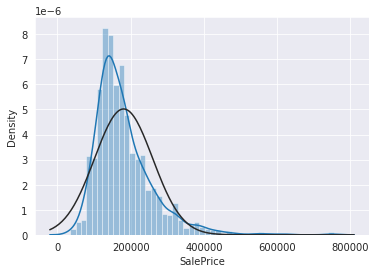

In [28]:
y=train['SalePrice']
# y=np.log1p(y)
sns.distplot(y,fit=norm)
print('处理前峰度',y.skew())
print('处理前偏度',y.kurtosis())
plt.show()

处理后峰度 0.12157976050304879
处理后偏度 0.8047507917418972


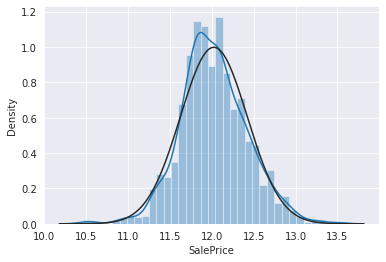

In [29]:

y=np.log1p(y)
sns.distplot(y,fit=norm)
print('处理后峰度',y.skew())
print('处理后偏度',y.kurtosis())
plt.show()

In [30]:
training=training.drop('SalePrice',axis=1)
print(training.shape)
print(len(y))
print(testing.shape)

(1458, 189)
1458
(1459, 189)


In [31]:
y.isnull().sum()

0

In [32]:
#模型预测
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
def ignore_warn(*args,**kwargs):
  pass
warnings.warn=ignore_warn
pd.set_option('display.float_format',lambda x:'{:.3f}'.format(x))#限制浮点数输出至小数点后3位

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb
#采用十折交叉验证
n_folds = 10

def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=20)
  rmse = np.sqrt(-cross_val_score(model, training.values, y.values, scoring='neg_mean_squared_error', cv=kf))
  return(rmse)
rid_alpha = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rid = make_pipeline(RobustScaler(), RidgeCV(alphas=rid_alpha))
models_name = ['Lasso', 'ElasticNet', 'Ridge', 'Gradient Boosting', 'LightGBM', 'XGBoost']
models = [rid]
for i, model in enumerate(models):
  score = rmse_cv(model)
  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))


Lasso score: nan(nan)


[0.05362452 0.05374122 0.05474117 0.05476235 0.05690879 0.05275896
 0.05516242 0.05089223 0.05694479 0.05433054]
[0.00287559 0.00288812 0.0029966  0.00299892 0.00323861 0.00278351
 0.00304289 0.00259002 0.00324271 0.00295181]


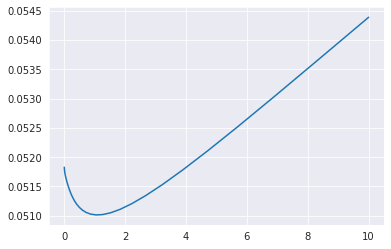

In [35]:
#岭回归——输出为nan的原因是cross_val_score函数中需要为training.values和y_train.values应该是列表或数组，而不是dataframe
#拟定不同的50个参数，通过交叉验证选取适合的参数。交叉验证，存储不同的alpha下，均方误差，通过绘图不同参数下的误差曲线查看最好的参数。
y_train=np.log1p(training)
alphas=np.logspace(-3,1,50)
test_scores=[]
for alpha in alphas:
  clf=Ridge(alpha)
  test_score=np.sqrt(-cross_val_score(clf,training.values,y_train.values,cv=10,scoring='neg_mean_squared_error'))
  test_scores.append(np.mean(test_score))
print(test_score)
print(-cross_val_score(clf,training.values,y_train.values,cv=10,scoring='neg_mean_squared_error'))
plt.plot(alphas,test_scores)
plt.show()
#进一步找到最佳位置
alphas=np.logspace(0,1,50)

0.0001 0.05085493768334991
0.00018329807108324357 0.050422146580370066
0.0003359818286283781 0.05014507065243055
0.0006158482110660267 0.05017706829811327
0.0011288378916846883 0.05072653963610867
0.00206913808111479 0.052150418766596464
0.00379269019073225 0.05518868533108233
0.0069519279617756054 0.06084993183862003
0.012742749857031334 0.07074587805567918
0.023357214690901212 0.08760642199362367
0.04281332398719392 0.10835518810098992
0.07847599703514607 0.13115105476878414
0.14384498882876628 0.15213858092230897
0.26366508987303583 0.16762018412292995
0.4832930238571752 0.18430322859111486
0.8858667904100823 0.21015435473633265
1.623776739188721 0.23400243464520337
2.9763514416313193 0.2599023152647788
5.455594781168514 0.28209239202397746
10.0 0.28821310345879414


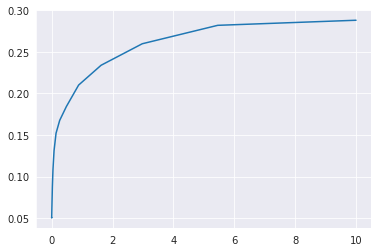

In [36]:
#Lasso——同样的问题cross_val_score函数
lasso_alpha = np.logspace(-4,1,20)
test_scores = []
for alpha in lasso_alpha:
    lasso =Lasso(alpha)
    test_score = np.sqrt(-cross_val_score(lasso, training.values, y_train.values, scoring='neg_mean_squared_error', cv=5))
    test_scores.append(np.mean(test_score))
    print(alpha,np.mean(test_score))
plt.plot(lasso_alpha,test_scores)
plt.show()

N:0.1,平均test_score:0.09596184275682404
N:0.3,平均test_score:0.09584162379443939
N:0.5,平均test_score:0.09591284441766715
N:0.7,平均test_score:0.09605967702928908
N:0.9,平均test_score:0.09595283439167462
N:0.99,平均test_score:0.09599308674407406


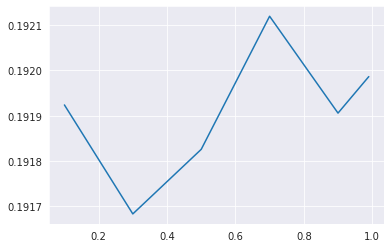

In [37]:
#随机森林——同样的问题cross_val_score函数
from sklearn.ensemble import RandomForestRegressor
Ns = [.1,.3,.5,.7,.9,.99]
test_scores = []
for N in Ns:
    clf = RandomForestRegressor(n_estimators=200, max_features=0.3)
    test_score = np.sqrt(-cross_val_score(clf, training.values, y_train.values, cv=5, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    print(f"N:{N},平均test_score:{sum(test_score)/10}")
 
plt.plot(Ns,test_scores)
plt.show()

In [38]:
#采用十折交叉验证
n_folds = 10
def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=20)
  rmse = np.sqrt(-cross_val_score(model, training.values, y.values, scoring='neg_mean_squared_error', cv=kf))
  return(rmse)

In [39]:
#岭回归Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb
rid_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
rid = make_pipeline(RobustScaler(), RidgeCV(alphas=rid_alpha))


In [40]:
#Lasso
lasso_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alpha, random_state=2))

In [41]:
#ElasticNet
enet_beta = [0.1, 0.2, 0.5, 0.6, 0.8, 0.9]
enet_alpha = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]
ENet = make_pipeline(RobustScaler(), ElasticNetCV(l1_ratio=enet_beta, alphas=enet_alpha, random_state=12))


In [42]:
#Gradient Boosting
gbr_params = {'loss': 'huber',
      'criterion': 'mse', 
      'learning_rate': 0.1,
      'n_estimators': 600, 
      'max_depth': 4,
      'subsample': 0.6,
      'min_samples_split': 20,
      'min_samples_leaf': 5,
      'max_features': 0.6,
      'random_state': 32,
      'alpha': 0.5}
gbr = GradientBoostingRegressor(**gbr_params)


In [43]:
#LightGBM
lgbr_params = {'learning_rate': 0.01,
      'n_estimators': 1850, 
      'max_depth': 4,
      'num_leaves': 20,
      'subsample': 0.6,
      'colsample_bytree': 0.6,
      'min_child_weight': 0.001,
      'min_child_samples': 21,
      'random_state': 42,
      'reg_alpha': 0,
      'reg_lambda': 0.05}
lgbr = lgb.LGBMRegressor(**lgbr_params)


In [44]:
#XGBoost
xgbr_params = {'learning_rate': 0.01,
      'n_estimators': 3000, 
      'max_depth': 5,
      'subsample': 0.6,
      'colsample_bytree': 0.7,
      'min_child_weight': 3,
      'seed': 52,
      'gamma': 0,
      'reg_alpha': 0,
      'reg_lambda': 1}
xgbr = xgb.XGBRegressor(**xgbr_params)


In [45]:
#单个模型评估
#采用十折交叉验证
n_folds = 10

def rmse_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=20)
  rmse = np.sqrt(-cross_val_score(model, training.values, y.values, scoring='neg_mean_squared_error', cv=kf))
  return(rmse)
models_name = ['Lasso', 'ElasticNet', 'Ridge', 'Gradient Boosting', 'LightGBM', 'XGBoost']
models = [lasso, ENet, rid, gbr, lgbr, xgbr]
for i, model in enumerate(models):
  score = rmse_cv(model)
  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))

Lasso score: 0.11271113690495871(0.007154399533817108)
ElasticNet score: 0.11299314982110964(0.007231543422679665)
Ridge score: 0.11391967129239818(0.007104735431614292)
Gradient Boosting score: 0.11881039362569237(0.008466107029126967)
LightGBM score: 0.12199843801920691(0.010502856056546536)
[11:23:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:39] WARNING: /workspace/src/objective/regression_obj.cu:152: re

In [46]:
#设置Stacking模型参数
stack_model = StackingCVRegressor(regressors=(lasso, ENet, rid, gbr, lgbr, xgbr), meta_regressor=lasso, use_features_in_secondary=True)

In [48]:
#在整个训练集上训练各模型
#Lasso
lasso_trained = lasso.fit(np.array(training), np.array(y))
#ElasticNet
ENet_trained = ENet.fit(np.array(training), np.array(y))
#Ridge
rid_trained = rid.fit(np.array(training), np.array(y))
#Gradient Boosting
gbr_trained = gbr.fit(np.array(training), np.array(y))
#LightGBM
lgbr_trained = lgbr.fit(np.array(training), np.array(y))
#XGBoost
xgbr_trained = xgbr.fit(np.array(training), np.array(y))
#Stacking
stack_model_trained = stack_model.fit(np.array(training), np.array(y))

[11:31:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:33:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:33:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:34:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [50]:
#评估各个模型在完整训练集上的表现
def rmse(y, y_preds):
  return np.sqrt(mean_squared_error(y, y_preds))
models.append(stack_model)
models_name.append('Stacking_model')
for i, model in enumerate(models):
  y_preds = model.predict(np.array(training))
  model_score = rmse(y, y_preds)
  print('RMSE of {}: {}'.format(models_name[i], model_score))

RMSE of Lasso: 0.09960736600534029
RMSE of ElasticNet: 0.09932291916848514
RMSE of Ridge: 0.09707591979999522
RMSE of Gradient Boosting: 0.06794523561658593
RMSE of LightGBM: 0.0642939069794497
RMSE of XGBoost: 0.02265839203082312
RMSE of Stacking_model: 0.0965471213778361


In [64]:
#提交各个模型的预测结果
sample_submission = pd.read_csv('/content/drive/MyDrive/data/kaggle/sample_submission.csv')
for i, model in enumerate(models):
  preds = model.predict(np.array(testing))
  submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(preds)})
  submission.to_csv('House_Price_submission_'+models_name[i]+'_optimation.csv', index=False)
  print('{} finished.'.format(models_name[i]))

Lasso finished.
ElasticNet finished.
Ridge finished.
Gradient Boosting finished.
LightGBM finished.
XGBoost finished.
Stacking_model finished.


In [51]:
#均值融合
preds_in_train = np.zeros((len(y), len(models)))
for i, model in enumerate(models):
  preds_in_train[:, i] = model.predict(np.array(training))
average_preds_in_train = preds_in_train.mean(axis=1)
average_score = rmse(y, average_preds_in_train)
print('RMSE of average model on training data:', average_score)

RMSE of average model on training data: 0.07299061010630922


In [65]:
#提交均值融合结果
#提交均值融合预测结果
preds_in_test = np.zeros((len(testing), len(models)))
for i, model in enumerate(models):
  preds_in_test[:, i] = model.predict(np.array(testing))
average_preds_in_test = preds_in_test.mean(axis=1)

average_submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(average_preds_in_test)})
average_submission.to_csv('House_Price_submission_average_model_optimation.csv', index=False)

In [55]:
#权值融合
model_weights = [0.15, 0.12, 0.08, 0.08, 0.12, 0.15, 0.3]
weight_preds_in_train = np.matmul(preds_in_train, model_weights)

weight_score = rmse(y, weight_preds_in_train)
print('RMSE of weight model on training data:', weight_score)

RMSE of weight model on training data: 0.07524096558737826


In [66]:
#提交权值融合预测结果
weight_preds_in_test = np.matmul(preds_in_test, model_weights)

weight_submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': np.expm1(weight_preds_in_test)})
weight_submission.to_csv('House_Price_submission_weight_model_optimation.csv', index=False)

In [57]:
#保存训练集上的预测结果
train_prediction = pd.DataFrame(preds_in_train, columns=models_name)
train_prediction.head()

,Lasso,ElasticNet,Ridge,Gradient Boosting,LightGBM,XGBoost,Stacking_model
0,12.240,12.240,12.237,12.241,12.209,12.233,12.236
1,12.131,12.133,12.154,12.109,12.067,12.107,12.154
2,12.277,12.276,12.274,12.312,12.253,12.293,12.301
3,12.078,12.078,12.067,12.030,11.976,11.871,12.046
4,12.598,12.598,12.600,12.505,12.514,12.478,12.612


In [58]:
train_prediction.shape

(1458, 7)

In [59]:
train_prediction.to_csv('train_prediction_of_7_models.csv', index=False)

In [60]:
#保存测试集上的预测结果
test_prediction = pd.DataFrame(preds_in_test, columns=models_name)
test_prediction.head()

,Lasso,ElasticNet,Ridge,Gradient Boosting,LightGBM,XGBoost,Stacking_model
0,11.707,11.710,11.728,11.775,11.696,11.748,11.676
1,11.955,11.955,11.954,11.996,11.957,12.023,11.956
2,12.098,12.097,12.086,12.135,12.112,12.118,12.077
3,12.186,12.184,12.172,12.173,12.177,12.161,12.140
4,12.227,12.228,12.225,12.139,12.162,12.133,12.235


In [61]:
test_prediction.shape

(1459, 7)

In [62]:
test_prediction.to_csv('test_prediction_of_7_models.csv', index=False)